In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torchvision

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.9.0+cu102  Device: cuda


In [26]:
BATCH_SIZE = 32
EPOCHS = 10

In [27]:
''' 3. 개미와 벌을 분류하기 위해 개미 이미지 데이터와 벌 이미지 데이터 불러오기 (Train set, Test set 분리하기) '''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder("../data/hymenoptera_data/"+x, data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True) for x in ['train', 'val']}

In [15]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [16]:
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


In [17]:
class_names = image_datasets['val'].classes
print(class_names)

['ants', 'bees']


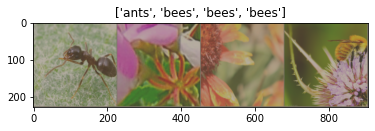

In [25]:
''' 5. 데이터 확인하기 (2) '''
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.
    
# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))
# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
''' 6. 불러온 특정 모델에 대하여 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [9]:
''' 7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [28]:
''' 8. PyTorch 내에서 제공하는 미리 학습되지 않은 ResNet18 모델 불러온 후 Output 크기 설정하기 '''
import torchvision.models as models
model = models.resnet18(pretrained = False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

In [29]:
''' 9. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
''' 10. 미리 학습되지 않은 ResNet18 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/244 (0%)]	Train Loss: 0.729698
Train Epoch: 1 [160/244 (62%)]	Train Loss: 0.744410

[EPOCH: 1], 	Test Loss: 0.8130, 	Test Accuracy: 45.10 % 

Train Epoch: 2 [0/244 (0%)]	Train Loss: 0.585420
Train Epoch: 2 [160/244 (62%)]	Train Loss: 0.830397

[EPOCH: 2], 	Test Loss: 0.7526, 	Test Accuracy: 53.59 % 

Train Epoch: 3 [0/244 (0%)]	Train Loss: 0.748287
Train Epoch: 3 [160/244 (62%)]	Train Loss: 0.654119

[EPOCH: 3], 	Test Loss: 0.7746, 	Test Accuracy: 50.98 % 

Train Epoch: 4 [0/244 (0%)]	Train Loss: 0.586260
Train Epoch: 4 [160/244 (62%)]	Train Loss: 0.591820

[EPOCH: 4], 	Test Loss: 0.7138, 	Test Accuracy: 50.33 % 

Train Epoch: 5 [0/244 (0%)]	Train Loss: 0.451213
Train Epoch: 5 [160/244 (62%)]	Train Loss: 0.579747

[EPOCH: 5], 	Test Loss: 0.6908, 	Test Accuracy: 56.21 % 

Train Epoch: 6 [0/244 (0%)]	Train Loss: 0.385662
Train Epoch: 6 [160/244 (62%)]	Train Loss: 0.483726

[EPOCH: 6], 	Test Loss: 0.5982, 	Test Accuracy: 72.55 % 

Train Epoch: 7 [0/244 (0%)]	Train Loss: 

In [31]:
''' 11. IMAGENET 데이터로 미리 학습이 된 ResNet18 모델을 불러온 후 개미, 벌 이미지 데이터에 맞게 Fine Tuning 해보기 '''
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/244 (0%)]	Train Loss: 0.653840
Train Epoch: 1 [160/244 (62%)]	Train Loss: 0.349608

[EPOCH: 1], 	Test Loss: 0.2032, 	Test Accuracy: 94.12 % 

Train Epoch: 2 [0/244 (0%)]	Train Loss: 0.148481
Train Epoch: 2 [160/244 (62%)]	Train Loss: 0.083132

[EPOCH: 2], 	Test Loss: 0.1596, 	Test Accuracy: 94.12 % 

Train Epoch: 3 [0/244 (0%)]	Train Loss: 0.230208
Train Epoch: 3 [160/244 (62%)]	Train Loss: 0.283385

[EPOCH: 3], 	Test Loss: 0.1631, 	Test Accuracy: 94.77 % 

Train Epoch: 4 [0/244 (0%)]	Train Loss: 0.158431
Train Epoch: 4 [160/244 (62%)]	Train Loss: 0.030180

[EPOCH: 4], 	Test Loss: 0.1427, 	Test Accuracy: 95.42 % 

Train Epoch: 5 [0/244 (0%)]	Train Loss: 0.106973
Train Epoch: 5 [160/244 (62%)]	Train Loss: 0.040670

[EPOCH: 5], 	Test Loss: 0.1510, 	Test Accuracy: 94.77 % 

Train Epoch: 6 [0/244 (0%)]	Train Loss: 0.028708
Train Epoch: 6 [160/244 (62%)]	Train Loss: 0.033924

[EPOCH: 6], 	Test Loss: 0.1674, 	Test Accuracy: 94.12 % 

Train Epoch: 7 [0/244 (0%)]	Train Loss: 

## ResNet13의 FC 이전은 weight freezing 시키고 fc부분만 fine-tuning 하기

In [34]:
from torch.optim import lr_scheduler # 스케쥴링 함수

model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = torch.optim.Adam(model_conv.fc.parameters(), lr = 0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [35]:
''' 6. 불러온 특정 모델에 대하여 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, scheduler, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [36]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, exp_lr_scheduler,log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

C:\Users\anpdi\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train Epoch: 1 [0/244 (0%)]	Train Loss: 0.021019
Train Epoch: 1 [160/244 (62%)]	Train Loss: 0.044604

[EPOCH: 1], 	Test Loss: 0.2315, 	Test Accuracy: 94.12 % 

Train Epoch: 2 [0/244 (0%)]	Train Loss: 0.036655
Train Epoch: 2 [160/244 (62%)]	Train Loss: 0.251848

[EPOCH: 2], 	Test Loss: 0.2564, 	Test Accuracy: 94.12 % 

Train Epoch: 3 [0/244 (0%)]	Train Loss: 0.027668
Train Epoch: 3 [160/244 (62%)]	Train Loss: 0.037309

[EPOCH: 3], 	Test Loss: 0.2501, 	Test Accuracy: 93.46 % 

Train Epoch: 4 [0/244 (0%)]	Train Loss: 0.036058
Train Epoch: 4 [160/244 (62%)]	Train Loss: 0.003625

[EPOCH: 4], 	Test Loss: 0.2776, 	Test Accuracy: 90.85 % 

Train Epoch: 5 [0/244 (0%)]	Train Loss: 0.223342
Train Epoch: 5 [160/244 (62%)]	Train Loss: 0.078358

[EPOCH: 5], 	Test Loss: 0.2802, 	Test Accuracy: 92.16 % 

Train Epoch: 6 [0/244 (0%)]	Train Loss: 0.122574
Train Epoch: 6 [160/244 (62%)]	Train Loss: 0.374859

[EPOCH: 6], 	Test Loss: 0.3234, 	Test Accuracy: 89.54 % 

Train Epoch: 7 [0/244 (0%)]	Train Loss: 